In [1]:
# General Data Science Libraries
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix


# Natural Language Processing Libraries
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import PorterStemmer  
from sklearn.feature_extraction.text import TfidfVectorizer
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings('ignore')

/kaggle/input/crickalike/shot_categorization.csv
/kaggle/input/crickalike/event_classifier.csv


In [2]:
df = pd.read_csv('/kaggle/input/crickalike/event_classifier.csv', index_col = [0])
df.tail()

,commentary,target
181,"Marco Jansen to Shubman Gill, FOUR, India off...",1
182,"Ngidi to Dhawan, FOUR, thwacks the drive outs...",1
183,"Marco Jansen to Shubman Gill, FOUR, short bal...",1
184,"Marco Jansen to Shreyas Iyer, SIX, slammed do...",2
185,"Nortje to Shreyas Iyer, SIX, a lot of jugglin...",2


In [3]:
def text_cleaning(df, column):
    df_column_array = np.array(df[column])
    text = []
    ps = PorterStemmer()
    for index in range(len(df_column_array)):
        modifiedText = remove_stopwords(df.at[index, column])
        stemmedSentence = ""
        for word in modifiedText.split():
            word = re.sub(r"[^a-zA-Z]+", '', word)
            word = word.strip()
            word = word.lower()
            word = ps.stem(word)
            word = word.strip()
            stemmedSentence += word
            stemmedSentence += " "
        df.at[index, column] = stemmedSentence

In [4]:
text_cleaning(df, 'commentary')

In [5]:
df.head()

,commentary,target
0,siraj maharaj bowl maharaj miser stay creas en...,0
1,thakur parnel caught shreya iyer parnel succum...,0
2,washington sundar markram caught dhawan two wi...,0
3,kuldeep yadav klaasen caught siraj good run ca...,0
4,siraj r hendrick caught shahbaz ahm hendrick d...,0


In [6]:
def vectorize(data, tfidf_vect_fit):
    x_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names()
    x_tfidf_df = pd.DataFrame(x_tfidf.toarray())
    x_tfidf_df.columns = words
    return (x_tfidf_df)

In [7]:
tfidf_vect = TfidfVectorizer(analyzer = 'word', stop_words = None, ngram_range=(1, 2), max_df = 0.5, use_idf = True, smooth_idf = True, max_features = 1500)
tfidf_vect_fit = tfidf_vect.fit(df['commentary'])

df.reset_index(drop = True, inplace = True)
df_temp = vectorize(df['commentary'], tfidf_vect_fit)
df_temp.reset_index(drop = True, inplace = True)

df = pd.concat([df, df_temp], axis = 1)

df.drop(columns = ['commentary'], inplace = True)

df.head()

,target,absolut,across,africa,again,ahm,ahm hendrick,ahm janneman,ahm klaasen,ahm markram,...,wri,wri smile,wrist,yadav,yadav hendrick,yadav klaasen,yadav marco,yadav miller,yadav phehlukwayo,yorker
0,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.124766,0.124766,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.212458,0.0,0.144488,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.214628,0.144741,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [8]:
smote_over_sample = SMOTE(sampling_strategy = 'minority')

x, y = smote_over_sample.fit_resample(df.drop(columns = 'target'), df['target'])

x_train, x_test, y_train, y_test = train_test_split(x, y,stratify = y, random_state = 1)

In [9]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    train_predictions = clf.predict(x_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(x_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
Accuracy: 54.7945%
Log Loss: 11.04923801772536
DecisionTreeClassifier
Accuracy: 95.8904%
Log Loss: 1.4194017696538654
RandomForestClassifier
Accuracy: 93.1507%
Log Loss: 0.2534331428772286
XGBClassifier
Accuracy: 98.6301%
Log Loss: 0.07693747778053153
AdaBoostClassifier
Accuracy: 94.5205%
Log Loss: 0.14826666893571813
GradientBoostingClassifier
Accuracy: 94.5205%
Log Loss: 0.23033761749106854
GaussianNB
Accuracy: 95.8904%
Log Loss: 1.4194017696538654
LinearDiscriminantAnalysis
Accuracy: 80.8219%
Log Loss: 0.5664964446431934


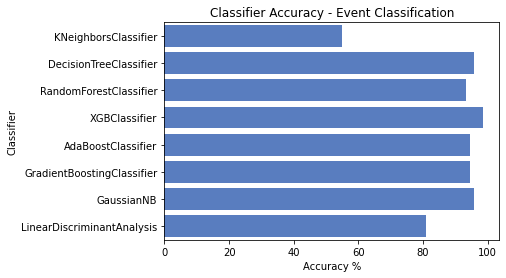

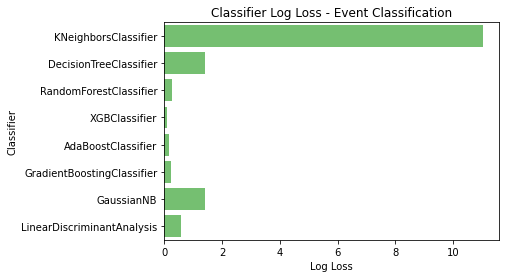

In [10]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy - Event Classification')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss - Event Classification')
plt.show()

In [11]:
print(len(y))
print(len(y_train))
print(len(y_test))

289
216
73


In [12]:
model = XGBClassifier(random_state = 42)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(accuracy_score(y_test, y_pred))

0.9863013698630136


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.97      1.00      0.98        32
           2       1.00      1.00      1.00        32

    accuracy                           0.99        73
   macro avg       0.99      0.96      0.98        73
weighted avg       0.99      0.99      0.99        73



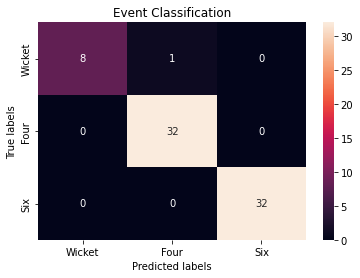

<Figure size 432x288 with 0 Axes>

In [14]:
Cm=confusion_matrix(y_test, y_pred)
ax=plt.axes()
sns.heatmap(Cm, annot = True, annot_kws = {'size':10}, ax = ax)
plt.title("Confusion Metrics")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Event Classification'); 
ax.xaxis.set_ticklabels(['Wicket', 'Four', 'Six']); ax.yaxis.set_ticklabels(['Wicket', 'Four', 'Six']);
plt.show()
plt.savefig('sc_cm.png')

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    from itertools import izip
    pc.update_scalarmappable()
    ax = pc.get_axes()
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in izip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Event Classification', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [16]:
# sampleClassificationReport = """             precision    recall  f1-score   support

#           Wicket       1.00      0.89      0.94         9
#           Four       0.97      1.00      0.98        32
#           Six       1.00      1.00      1.00        32
#           macro avg       0.99      0.99      0.99       595
#           weighted avg       0.99      0.99      0.99       595"""


# plot_classification_report(sampleClassificationReport)
# plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
# plt.close()

In [17]:
def computeAccuracy(df, number_of_features):
    pca = PCA(n_components = number_of_features)
    
    features = np.array(df.drop(columns = 'target'))
    features_reduced = pca.fit_transform(features)
    
    labels = df['target'].tolist()
    
    x_train, x_test, y_train, y_test = train_test_split(features_reduced, labels, stratify = labels, random_state = 1)
    
    model = XGBClassifier(random_state = 42)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    return accuracy_score(y_test, y_pred);

In [18]:
score = [computeAccuracy(df, i) for i in range(1, 8)]
score

[0.574468085106383,
 0.5957446808510638,
 0.5531914893617021,
 0.5957446808510638,
 0.6382978723404256,
 0.6382978723404256,
 0.7021276595744681]

In [19]:
space = {
        'objective': 'multi:softprob',
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.loguniform('reg_alpha', 1e-8,100),
        'reg_lambda' : hp.loguniform('reg_lambda', 1e-8,100),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1800,
        'seed': 0,
        'learning_rate': hp.quniform("learning_rate", 1e-2, 0.25),
        'max_depth': hp.uniform('max_depth', 1, 7)
}

def objective(space, df_train, df_test):
    clf = XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']), min_child_weight = int(space['min_child_weight']),
                    colsample_bytree = int(space['colsample_bytree']))
        
    xx_train = df_train.drop(columns = ['target'])
    yy_train = df_train['target']
    
    xx_test = df_test.drop(columns = ['target'])
    yy_test = df_test['target']
    
    evaluation = [(xx_train, yy_train), 
                  (xx_test, yy_test)]
    
    clf.fit(xx_train, yy_train, eval_set=evaluation, eval_metric=None, early_stopping_rounds=20,verbose=False)
    
    pred = clf.predict(xx_test)
    accuracy = accuracy_score(yy_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

# best_hyperparams = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials)

In [20]:
sorted_columns = list(df.columns)
sorted_columns.remove('target')
sorted_columns = sorted(sorted_columns)

final_ordered_features = []

for col in sorted_columns:
    
    final_ordered_features.append(col)

print(len(final_ordered_features))

1500


In [21]:
with open('tf_idf_event', 'wb') as files:
    pickle.dump(tfidf_vect, files)

In [22]:
with open('event_classification', 'wb') as files:
    pickle.dump(model, files)

In [23]:
with open('final_ordered_event', 'wb') as files:
    pickle.dump(final_ordered_features, files)